### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

### 1. Set up spark context and SparkSession

In [1]:
from pyspark.sql import SparkSession
import time

In [2]:
path = "TICKET.csv"  # the path of file where datas will retrieved

In [3]:
###
import numpy as np
import pandas as pd
from itertools import chain
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
###

In [4]:
spark = SparkSession \
        .builder \
        .appName("Ucuş tipi tahminleme multinomial logical regression") \
        .getOrCreate()

#.config("spark.some.config.option", "some.value") \

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/home/datascience/spark_conf_dir/oci-hdfs-full-3.3.0.6.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


### 2. Load dataset

In [5]:
df = spark.read.format('com.databricks.spark.csv') \
            .options(header='true', inferschema='true') \
            .load(path, header=True);

# obtaining data

In [6]:
# Extracting datas on OND column
def ond_to_dep(x):
    return str(str(x).split("-")[0])

def ond_to_arr(x):
    return str(str(x).split("-")[1])

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType, IntegerType

ond_to_dep_udf = udf(lambda x: ond_to_dep(x), StringType())
df = df.withColumn("DEP_CITY", ond_to_dep_udf("OND"))

ond_to_arr_udf = udf(lambda x: ond_to_arr(x), StringType())
df = df.withColumn("ARR_CITY", ond_to_arr_udf("OND"))

In [7]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_stats = df.select(
    _mean(col('CUST_AGE')).alias('mean')
).collect()

"""
df_stats = df.select(
    _mean(col('CUST_AGE')).alias('mean'),
    _stddev(col('CUST_AGE')).alias('std')
).collect()
"""

year_mean = df_stats[0]['mean']
#year_std = df_stats[0]['std']

df = df.fillna(year_mean, subset=["CUST_AGE"])

# empty cells on CUST_AGE are fillling with average value of CUST_AGE column



In [8]:
df = df.drop("NTNLT1") # Removing NTNLT1 column since most of it's cells are N/A

df = df.na.drop()

df = df.filter(df['FLIGHT_REASON'] != 'NONE')

df.groupBy("FLIGHT_REASON").count().toPandas()

,FLIGHT_REASON,count
0,LEISURE,576739
1,SECOND HOME,259011
2,STUDENT,1228
3,BUSINESS,458593


In [9]:
# copying STUDENT flight type rows on FLIGHT_REASON column because there's not many STUDENT flight type when compared with other ones

from pyspark.sql.functions import col, explode, array, lit


major_df = df.filter(col("FLIGHT_REASON") != "STUDENT")
minor_df = df.filter(col("FLIGHT_REASON") == "STUDENT")
ratio = int(major_df.count()/minor_df.count() / 3 ) # dividing by 3 because total count of flight type that is not STUDENT is 3
print("ratio: {}".format(ratio))

ratio: 351


In [10]:
a = range(ratio)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)
df = combined_df

In [11]:
df.groupBy("FLIGHT_REASON").count().toPandas()

,FLIGHT_REASON,count
0,LEISURE,576739
1,SECOND HOME,259011
2,STUDENT,431028
3,BUSINESS,458593


In [12]:
def date_to_year(x):
    return int(str(x)[0:4])

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType, IntegerType


date_to_year_udf = udf(lambda x: date_to_year(x), IntegerType())
df = df.withColumn("ID_PNR_CREATION_YEAR", date_to_year_udf("ID_PNR_CREATION_YMD"))

# producing ID_PNR_CREATION_YEAR column with using ID_PNR_CREATION_YMD.

### 3. Deal with categorical data and Convert the data to dense vector

In [13]:
# a function which converts the columns hasn't digital values to a shape that StringIndexer and VectorIndexer can understand
def get_dummy(df,categoricalCols,continuousCols,labelCol):
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col
    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in categoricalCols ]
    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers ]
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders] + continuousCols, outputCol="features")
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    model=pipeline.fit(df)
    data = model.transform(df)
    data = data.withColumn('label',col(labelCol))
    return data.select('features','label')


In [14]:
categoricalCols = ["DEP_CITY","ARR_CITY"]
continuousCols = ['PNR_PSSG_COUNT','CHILD_FLG','INFANT_FLG','POS_POC_SAME_FLG','SAME_SRNAME_FLG','FAMILY_FLG','SEAT_SELECT_FLG','XBAG_FIRST_FLT_FLG','XBAG_LAST_FLT_FLG','XBAG_TWO_WAY_FLT_FLG','SPORT_FLG','XBAG_FLG','PET_FLG','CUST_AGE','ID_PNR_CREATION_YEAR']
labelCol = "FLIGHT_REASON"

# columns that are useful for machine learning

df_features = get_dummy(df,categoricalCols,continuousCols,labelCol)

### 4. Transform the dataset to DataFrame

In [15]:
from pyspark.ml.linalg import Vectors # !!!!caution: NOT from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

"""
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['PNR_NO','ID_TKT_NO','ID_PNR_CREATION_YMD', 'features','label'])   
"""   

"\ndef transData(data):\n    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['PNR_NO','ID_TKT_NO','ID_PNR_CREATION_YMD', 'features','label'])   \n"

In [16]:
# Index labels, adding metadata to the label column

labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(df_features)
#df_features
labelIndexer.transform(df_features).show(5, True)

+--------------------+--------+------------+
|            features|   label|indexedLabel|
+--------------------+--------+------------+
|(151,[22,68,136,1...|BUSINESS|         1.0|
|(151,[0,72,136,13...|BUSINESS|         1.0|
|(151,[0,75,136,14...|BUSINESS|         1.0|
|(151,[1,68,136,14...|BUSINESS|         1.0|
|(151,[0,103,136,1...|BUSINESS|         1.0|
+--------------------+--------+------------+
only showing top 5 rows



Traceback (most recent call last):                                  (0 + 1) / 1]
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 642, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 595, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/datascience/conda/p

In [17]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df_features)
featureIndexer.transform(df_features).show(5, True)

+--------------------+--------+--------------------+
|            features|   label|     indexedFeatures|
+--------------------+--------+--------------------+
|(151,[22,68,136,1...|BUSINESS|(151,[22,68,136,1...|
|(151,[0,72,136,13...|BUSINESS|(151,[0,72,136,13...|
|(151,[0,75,136,14...|BUSINESS|(151,[0,75,136,14...|
|(151,[1,68,136,14...|BUSINESS|(151,[1,68,136,14...|
|(151,[0,103,136,1...|BUSINESS|(151,[0,103,136,1...|
+--------------------+--------+--------------------+
only showing top 5 rows



Traceback (most recent call last):
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 642, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 595, in read_int
    raise EOFError
EOFError
Traceback (most recent call last):
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/datascience/conda/pyspark30_p37_cpu_v2/lib/python3.7/site-package

In [18]:
from pyspark.sql.functions import monotonically_increasing_id

In [19]:
df_features = df_features.withColumn("id", monotonically_increasing_id())

df = df.withColumn("id", monotonically_increasing_id())

df_features_cols = df_features.columns
df_features_cols.remove('id')

df_cols = df.columns
df_cols.remove('id')

df_merged = df.join(df_features, df["id"] == df_features["id"])

### 5. Split the data to training and test data sets

In [20]:
# data is, splitting to train and test data. (%40 for the test)

df_merged_train, df_merged_test = df_merged.randomSplit([0.6, 0.4], seed = 2018)

(trainingData, testData) = df_merged_train.select(df_features_cols), df_merged_test.select(df_features_cols)
(trainingDF, testDF) = df_merged_train.select(df_cols), df_merged_test.select(df_cols)


### 6. Fit Multinomial logisticRegression Classification Model

In [21]:
# applying logistic regression since the value we need to predict has only four possible result.

from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol = 'indexedLabel')

### 

In [22]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol = "predictedLabel",labels=labelIndexer.labels)

In [23]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr, labelConverter])

In [24]:
# Training the model with train data.
model = pipeline.fit(trainingData)

### 8. Make predictions

In [25]:
# predicting
predictions = model.transform(testData)

### 9. Evaluation

In [26]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.128353


In [27]:
start = time.time()

predictions_train = model.transform(trainingData)
y_true = predictions_train.select(['label']).collect() # doğru değerler
y_pred = predictions_train.select(['predictedLabel']).collect() # model tarafından tahmin edilen değerler
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

end = time.time()
print(end - start)

              precision    recall  f1-score   support

    BUSINESS       0.87      0.88      0.87    275078
     LEISURE       0.87      0.79      0.83    346209
 SECOND HOME       0.79      0.89      0.84    155353
     STUDENT       0.93      0.97      0.95    258890

    accuracy                           0.87   1035530
   macro avg       0.87      0.88      0.87   1035530
weighted avg       0.87      0.87      0.87   1035530

155.7912631034851


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    """"
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_names = map(str, class_temp)

class_names_list = list(class_names)

In [30]:
print(class_names_list)

['LEISURE', 'BUSINESS', 'STUDENT', 'SECOND HOME']


In [31]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

In [32]:
y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()
cnf_matrix = confusion_matrix(y_true, y_pred, labels = class_names_list)
cnf_matrix

array([[182542,  20934,   5012,  22042],
       [ 16686, 160461,   6056,    312],
       [  1552,   2604, 166491,   1491],
       [  8846,    422,   2586,  91804]])

Confusion matrix, without normalization
[[182542  20934   5012  22042]
 [ 16686 160461   6056    312]
 [  1552   2604 166491   1491]
 [  8846    422   2586  91804]]


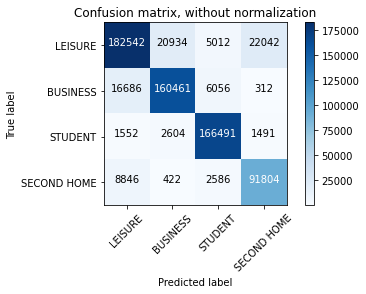

In [33]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes= class_names_list, title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix


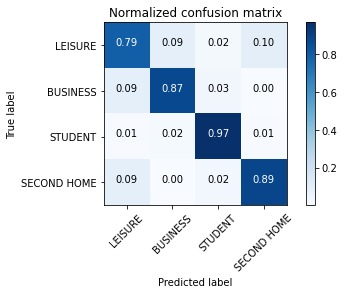

In [34]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes = class_names_list, normalize=True, title='Normalized confusion matrix')
plt.show()
